In [19]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
import pandas
DR14Q_v4_4 = fits.open('./DR14Q_v4_4.fits')
DR14Q_v4_4.info()
data = DR14Q_v4_4[1].data

Filename: ./DR14Q_v4_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7055,)   uint8   
  1  DR14Q_v4_4    1 BinTableHDU    328   526356R x 105C   [18A, D, D, J, I, J, I, 4A, D, D, 4A, D, D, D, I, D, D, D, K, K, K, K, K, K, I, I, I, 51J, 51J, 51J, 51A, D, D, I, A, I, I, A, 5D, 5D, 5D, 5D, D, 5D, D, D, D, D, D, D, D, D, D, D, D, E, D, D, D, D, D, D, E, I, D, D, E, I, D, D, E, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 4A, 4A, D, E, D, D, D, D, D, D, D, D, I, D, D, D]   


In [3]:
# to get the list of data
# criterion is redshift and whether XMM-Newton observation
# additional criterion is whether Galactic extinction available for SDSS_DR14
datacubelist = []
for i in range(len(data)):
    if 1.2 < data[i]['Z'] < 1.5:
        if data[i]['FLUX_0.2_2.0keV'] > 0:
            if data[i]['GAL_EXT'][0] > 0: 
                datacubelist.append(data[i])
datacubearray = np.array(datacubelist)

In [4]:
# If I get a name, with this function I can get the column index of datacubelist
def Namesindex(Name):
    for i in range(len(data.names)):
        if Name == data.names[i]:
            return i

# Constants
c = 3*10**10 # cm/s
H0 = 67.8*10**5 # cm/s/Mpc
Omega_m = 0.308
Omega_l = 0.692
h = 6.63*10**(-27) # erg s
eV = 1.6*10**(-12) # erg
Jy = 10**(-23) # erg/s/cm^2/Hz

# K correction function
def z2dL(redshift):
    z = 0
    dz = redshift/1000
    integrate = 0
    for i in range(1000):
        integrate += dz*(Omega_m*(1+z)**3+Omega_l)**(-0.5)
        z += dz
    return integrate*c*(1+redshift)/H0*3.086*10**24 # return distance of unit centimeter
def Flux2Lr_nu(obsflux,z): # Observed Flux to Luminosity of frequency nu at rest frame
    dL = z2dL(z)
    return 4*np.pi*dL**2*obsflux/(1+z)
# def Flux2Lr_lambda(obsflux,z): # Observed Flux to Luminosity of wavelength lambda at rest frame
#     dL = z2dL(z)
#     return 4*np.pi*dL**2*(1+z)*obsflux
def Flux2Lr(obsflux,z): # Observed Flux to Luminosity of all bandpass at rest frame 
    dL = z2dL(z)
    return 4*np.pi*dL**2*obsflux

In [5]:
# calculate the Luminosity of X-ray at 2keV
def softXray_nu(index, photon_index):
    # get the data of softXray and reshift
    softXray = datacubelist[index][Namesindex('FLUX_0.2_2.0keV')]
    redshift = datacubelist[index][Namesindex('Z')] 
    # convert the Flux into Luminosity of rest frame
    softXray = Flux2Lr(softXray,redshift)
    # We put the softXray Luminosity of bandpass and expected photon index to get the monochromatic softXray
    lower_frequency = 0.2*10**3*eV/h*(1+redshift) # 0.2 keV redshift correction
    upper_frequency = 2*10**3*eV/h*(1+redshift) # 2 keV redshift correction
    # integrate function
    def powerlaw_integrate(pl_index):
        integrate = 0
        nu = lower_frequency
        dnu = (upper_frequency-lower_frequency)/1000
        for i in range(1000):
            integrate += dnu*nu**(pl_index)
            nu += dnu
        return integrate
    def powerlaw_minus1():
        return np.log(upper_frequency/lower_frequency)
    # get the power law constant C in C*nu**(index)
    C = softXray/powerlaw_integrate(1-photon_index)
    #C = softXray/powerlaw_minus1()
    # the frequency of 2keV at rest frame
    nu0 = 2*10**3*eV/h
    return [C*nu0**(1-photon_index),softXray]

# get the soft X-ray luminosity at 2keV of rest frame
# Assume that photon index = 2
Xray2keV = np.array([])
Xraysoftband = np.array([])
for each in range(len(datacubelist)):
    Xray2keV = np.append(Xray2keV, softXray_nu(each,2)[0])
    Xraysoftband = np.append(Xraysoftband, softXray_nu(each,2)[1])

(array([  4.,   1.,   2.,   5.,   4.,  14.,  21.,  45.,  56.,  82., 114.,
        178., 167., 191., 180., 136.,  89.,  75.,  28.,  23.,  11.,   4.,
          4.,   0.,   0.,   1.,   0.,   0.,   0.,   2.]),
 array([24.58084712, 24.69730011, 24.8137531 , 24.93020608, 25.04665907,
        25.16311205, 25.27956504, 25.39601803, 25.51247101, 25.628924  ,
        25.74537698, 25.86182997, 25.97828295, 26.09473594, 26.21118893,
        26.32764191, 26.4440949 , 26.56054788, 26.67700087, 26.79345386,
        26.90990684, 27.02635983, 27.14281281, 27.2592658 , 27.37571878,
        27.49217177, 27.60862476, 27.72507774, 27.84153073, 27.95798371,
        28.0744367 ]),
 <a list of 30 Patch objects>)

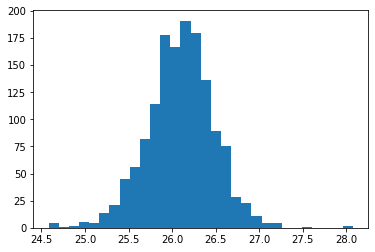

In [6]:
plt.hist(np.log10(Xray2keV), bins=30)
#plt.xlabel('')

In [7]:
# calculate the Luminosity of Ultroviolet 2500A of rest frame
# 2500A will redshift to bandpass between green and red band
def grmag2UV2500A(index):
    # only green(g) and red(r) bands are extracted for one quasar with index
    grmag = datacubelist[index][Namesindex('PSFMAG')][1:3]
    grext_gl = datacubelist[index][Namesindex('GAL_EXT')][1:3]
    grflux = 10**(-(grmag-grext_gl)/2.5)*3631*Jy
    redshift = datacubelist[index][Namesindex('Z')]
    flux_g, flux_r = Flux2Lr_nu(grflux,redshift) # get flux of green and red band of rest frame
    
    nu_2500A = c/(2500*10**(-8))
    nu_g = c/(4770*10**(-8))*(1+redshift)
    nu_r = c/(6231*10**(-8))*(1+redshift) # convert into frequency coordinates
    slope = np.log(flux_g/flux_r)/np.log(nu_g/nu_r)
    UV2500A = np.exp(np.log(flux_r) + slope*np.log(nu_2500A/nu_r))
    #print(flux_r, flux_g)
    # spectra index investigae
    return [slope, UV2500A, flux_g, flux_r]

UV2500A = np.array([])
UVindex = np.array([])
flux_g = np.array([])
flux_r = np.array([])
for each in range(len(datacubelist)):
    # only green(g) and red(r) bands are extracted
    UVindex = np.append(UVindex, grmag2UV2500A(each)[0])
    UV2500A = np.append(UV2500A, grmag2UV2500A(each)[1])
    flux_g = np.append(flux_g, grmag2UV2500A(each)[2])
    flux_r = np.append(flux_r, grmag2UV2500A(each)[3])


-1.18956185358335 0.885319434027591


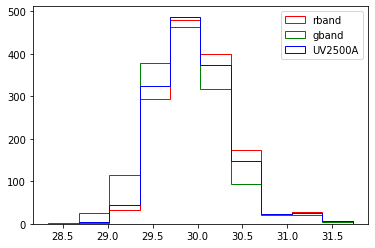

In [8]:
print(np.mean(UVindex),np.std(UVindex))
L_multi = [np.log10(UV2500A), np.log10(flux_g), np.log10(flux_r)]
label_multi = ['UV2500A', 'gband', 'rband']
color_multi = ['b','g','r']
plt.hist(L_multi, bins=10, label=label_multi, alpha=1, fill=False, color=color_multi ,histtype='step',stacked=False)
#plt.hist(np.log10(UV2500A),bins=30, label='UV2500A',color='b')
#plt.hist(np.log10(flux_g),bins=30, label='gband',color='g')
#plt.hist(np.log10(flux_r),bins=30, label='rband',color='r')
#plt.hist(UVindex, bins=50)
plt.legend()

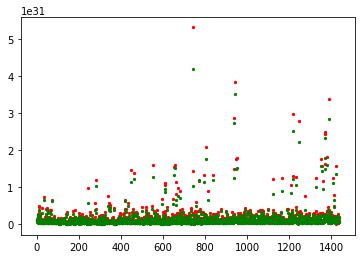

In [9]:
#np.linspace(0,1437,1437)
plt.scatter(np.linspace(0,1437,1437), flux_r, color='r',s=5)
plt.scatter(np.linspace(0,1437,1437), flux_g, color='g',s=5)

### Let's Calculate the $\alpha_{OX}$

By definition $\alpha_{OX}$ should be:

$$\alpha_{OX} \equiv \frac{\log[L_\nu(2500A)/L_\nu(2keV)]}{\log[\nu(2500A)/\nu(2keV)]} = 0.384\log[L_\nu(2keV)/L_\nu(2500A)]$$

[1.40230759 1.60069725 1.37279679 ... 1.34522793 1.66108432 1.35975768]
[1.43473474 1.43047452 1.45989101 ... 1.42090006 1.47780895 1.43201368]
0.20823040042322735 -4.7540500997625506


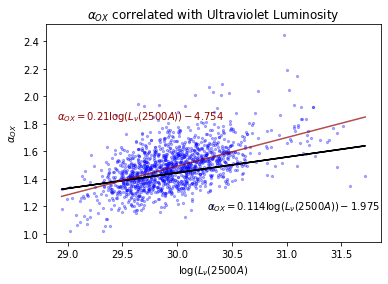

In [10]:
# Alpha_OX calculator
def alpha_OX(Xray2keV, UV2500A):
    return -np.log10(Xray2keV/UV2500A)/2.605

# figure of correlation
alpha_OX = alpha_OX(Xray2keV, UV2500A)
print(alpha_OX)
print(0.114*np.log10(UV2500A)-1.975)
plt.scatter(np.log10(UV2500A), alpha_OX, alpha=0.3, c = 'b', s=5)
plt.plot((np.log10(UV2500A)), 0.114*np.log10(UV2500A)-1.975, c = 'k')
plt.annotate(r'$\alpha_{OX}=0.114\log(L_\nu(2500A))-1.975$',xy=(30,1.4),textcoords='offset points',xytext=(30,-30),fontsize=10,c='k')
plt.xlabel(r'$\log(L_\nu(2500A)$')
plt.ylabel(r'$\alpha_{OX}$')
plt.title(r'$\alpha_{OX}\ $''correlated with Ultraviolet Luminosity')

# linear fit
from scipy import optimize
def f_1(x,A,B):
    return A*x+B
A,B = optimize.curve_fit(f_1, np.log10(UV2500A), alpha_OX)[0]
print(A, B)
plt.plot(np.log10(np.linspace(np.min(UV2500A),np.max(UV2500A))), A*np.log10(np.linspace(np.min(UV2500A),np.max(UV2500A)))+B,'#900302',alpha = 0.7)
plt.annotate(r'$\alpha_{OX}=%(Afit)s\log(L_\nu(2500A))%(Bfit)s$'%{"Afit":str(round(A,2))[0:4],"Bfit":str(round(B,3))[0:6]},xy=(30,1.4),
             textcoords='offset points',xytext=(-120,60),fontsize=10,c='#900302')

plt.savefig('alphaOX_LUV2500A.png', dpi=600)

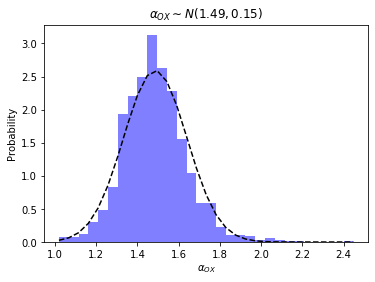

In [39]:
num_bins = 30
mu_alpha = np.mean(alpha_OX)
sigma_alpha = np.std(alpha_OX)
n, bins, patches = plt.hist(alpha_OX, num_bins, density = 1, facecolor = 'blue', alpha = 0.5)
y = scipy.stats.norm.pdf(bins, mu_alpha, sigma_alpha)#拟合一条最佳正态分布曲线y 
plt.plot(bins, y, 'k--') #绘制y的曲线 
plt.xlabel(r'$\alpha_{OX}$') #绘制x轴 
plt.ylabel('Probability') #绘制y轴 
plt.title(r'$\alpha_{OX}\sim N(%(mu)s,%(sigma)s)$' %{"mu":str(round(mu_alpha,2))[0:4], "sigma":str(round(sigma_alpha,2))[0:4]})
plt.subplots_adjust(left=0.15)#左边距 

In [598]:
print(Namesindex('FLUX_0.2_2.0keV'))

47


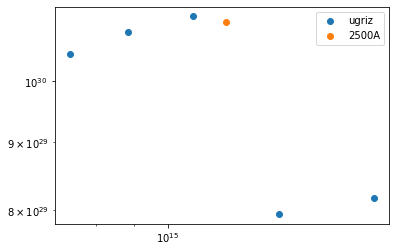

In [957]:
import matplotlib.pyplot as plt
def UVfit(index):
    ugrizmag = np.array(datacubelist[index][Namesindex('PSFMAG')])
    ugrizext = np.array(datacubelist[index][Namesindex('GAL_EXT')])
    ugrizflux = 10**(-(ugrizmag-ugrizext)/2.5)*3631*Jy  #unit: erg/s/cm^2/Hz
    ugrizlumin = Flux2Lr_nu(ugrizflux,datacubelist[index][Namesindex('Z')])
    ugriz = np.array([3543,4770,6231,7625,9134]) # unit: Amstrong

    plt.scatter(c/(ugriz*10**(-8)/(1+np.array(datacubelist[index][Namesindex('Z')]))), ugrizlumin, label='ugriz')
    plt.scatter(c/(2500*10**(-8)), 0.99*ugrizlumin[2], label='2500A')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('UVfit.pdf')
UVfit(500)

In [657]:
np.array(datacubelist[1][Namesindex('GAL_EXT')])

array([0.47941545, 0.37355727, 0.25842518, 0.19203761, 0.1428407 ])

In [403]:
import astropy.constants as C
(C.h).cgs

<Quantity 6.62607004e-27 erg s>

<center> <font size=5>Following are testing code</font>

In [635]:
nannumber = 0
for index in range(len(datacubelist)):
    grmag = datacubelist[index][Namesindex('PSFMAG')][1:3]
    grext_gl = datacubelist[index][Namesindex('GAL_EXT')][1:3]
    grflux = 10**(-9-(grmag-grext_gl)/2.5)*3631*Jy
    if grflux[1] == 0:
        # print(datacubelist[index][Namesindex('PSFFLUX')])
        nannumber += 1
        if nannumber < 10:
            print(datacubelist[index]['PSFMAG'], datacubelist[index]['GAL_EXT'],datacubelist[index]['PSFFLUX'])
            print('====================================================================')
print(nannumber)

0


In [636]:
nannumber = 0
for index in range(len(datacubelist)):
    if datacubelist[index][Namesindex('PSFFLUX')][1:2] < 0:
        # print(datacubelist[index][Namesindex('PSFFLUX')])
        nannumber += 1
        if nannumber < 10:
            print(datacubelist[index]['PSFMAG'], datacubelist[index]['GAL_EXT'],datacubelist[index]['PSFFLUX'])
            print('====================================================================')
print(nannumber)


0


In [535]:
len(datacubelist)

1437

In [634]:
data[1]['PSFFLUX']

array([1.11972964, 2.25051522, 2.90613604, 3.05413961, 4.73010159])

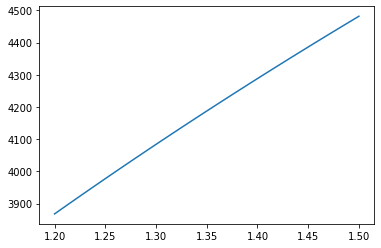

In [804]:
z = np.linspace(1.2,1.5,100)
plt.plot(z,z2dL(z)/3.086/10**24/(1+z))

In [805]:
z2dL(1.5)/3.086/10**24/(1+1.5)

4481.919784932188

In [974]:
help(round)

Help on built-in function round in module builtins:

round(number, ndigits=None)
    Round a number to a given precision in decimal digits.
    
    The return value is an integer if ndigits is omitted or None.  Otherwise
    the return value has the same type as the number.  ndigits may be negative.

